# Generate random variables from discrete distributions

In this exercise we will make both discrete distributions from the uniform distribution.

In [1]:
from stochastics import lcg_generator, take, head
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

Simulating the geometric distribution.

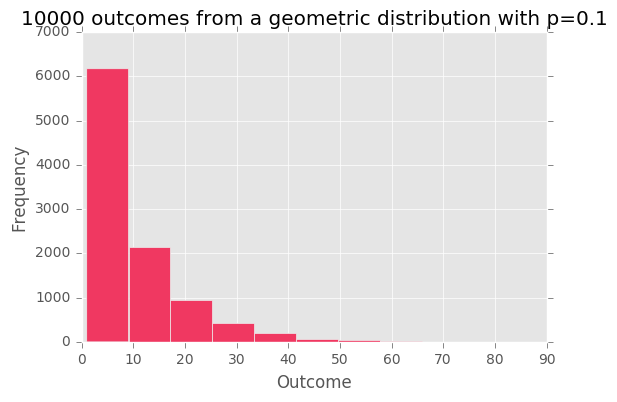

In [26]:
n = 10000
geom = np.random.geometric(0.1, n)

plt.hist(geom, color="#F03861")

plt.xlabel("Outcome")
plt.ylabel("Frequency")
plt.title("10000 outcomes from a geometric distribution with p=0.1")

plt.show()

## Six-point distribution

We simulate a non-uniform discrete distribution of a six-sided die with outcomes $X = \{ 1, 2, 3, 4, 5, 6 \}$. For this we use three different methods of generation based on the uniform distribution. The probability distribution is seen below.

In [3]:
x = np.array([1, 2, 3, 4, 5, 6])
p = np.array([7/48, 5/48, 1/8, 1/16, 1/4, 5/16])

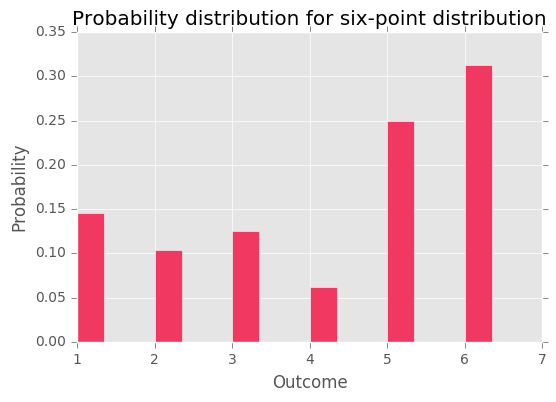

In [4]:
fig, ax = plt.subplots()

w = 0.35
ax.bar(np.arange(1, len(x)+1), p, w, color='#F03861')

plt.xlabel("Outcome")
plt.ylabel("Probability")
plt.title("Probability distribution for six-point distribution")

plt.show()

### Crude solution (bisection) for 6-point distribution

This method uses binary partitions to find a suitable random number.

In [5]:
from bisect import bisect_left

def crude(x, p):
    intervals = [head(p)]

    for i in range(1, len(p)):
        intervals.append(intervals[i-1] + p[i])

    while True:
        U = np.random.uniform(0, 1)
        i = bisect_left(intervals, U)

        if i:
            yield i
        else:
            yield 0

### Alias method

Using the alias method we simulate the given six point distribution. Based partly on `https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/`

In [6]:
def alias(x, p):
    def setup():
        n = len(p)
        F = n * p

        eps = 1e-5

        # Lookup table to know which to switch to
        aliases = np.zeros(n, dtype=np.int)

        # Partition into two subarrays
        larger  = list(*np.where(F >= 1))
        smaller = list(*np.where(F <= 1))

        while smaller and larger:
            small = smaller.pop()
            large = larger.pop()

            # The smallest value has the alias of the largest
            aliases[small] = large
            F[large] = F[large] - (1 - F[small])

            # There is still room, rerun.
            if F[large] < 1.0 - eps:
                smaller.append(large)
            else:
                larger.append(large)

        return aliases, F

    def draw(aliases, F):
        n = len(F)
        I = int(np.floor(n * np.random.uniform(0, 1)))

        if np.random.uniform(0, 1) < F[I]:
            return x[I]
        else:
            return x[aliases[I]]

    aliases, F = setup()

    while True:
        yield draw(aliases, F)

### Rejection method solution for 6-point distribtion

In [19]:
def rejection(x, p):
    c = max(p) + (1 - max(p))/2
    n = len(p)

    while True:
        U1, U2 = np.random.uniform(0, 1, 2);
        I = int(n * U1)
        if U2 < p[I] / c:
            yield I
        else:
            rejection(x, p)

In [20]:
crude_generator = crude(x, p)
alias_generator = alias(x, p)
rejection_generator = rejection(x, p)

### Chisquare validation

In [21]:
from scipy.stats import chisquare

n = 10000 # random numbers generated

#Compute frequencies for crude method
f_crude = np.bincount(take(crude_generator, 10000))

# Compute frequencies for rejection method
f_reject = np.bincount(take(rejection_generator, 10000))

print(p*n)
print(f_crude)
print(chisquare(f_crude, p*n))

print(p*n)
print(f_reject)
print(chisquare(f_reject, p*n))

[ 1458.33333333  1041.66666667  1250.           625.          2500.          3125.        ]
[1457 1019 1234  623 2595 3072]
Power_divergenceResult(statistic=5.2145257142857178, pvalue=0.39026426563601269)
[ 1458.33333333  1041.66666667  1250.           625.          2500.          3125.        ]
[1482 1070 1237  618 2514 3079]
Power_divergenceResult(statistic=2.1238628571428482, pvalue=0.83175442173038383)


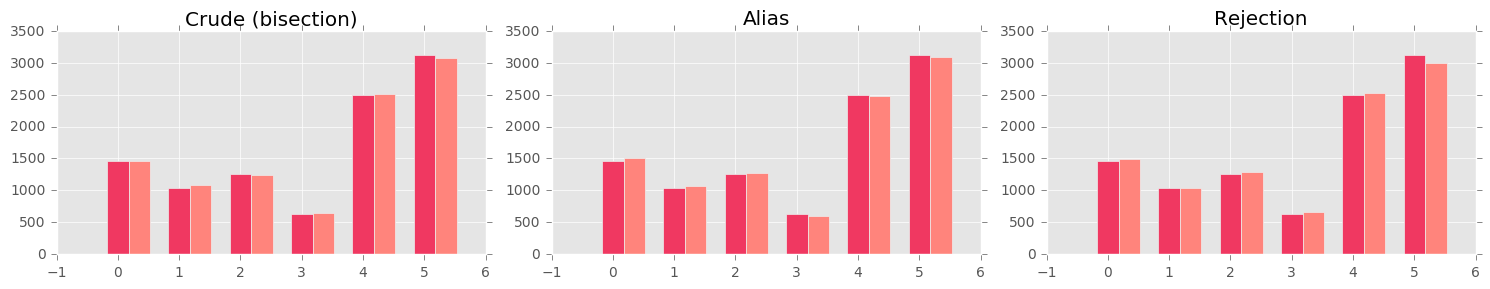

In [24]:
ind = np.arange(len(x))  # the x locations for the groups
width = 0.35             # the width of the bars

# Plot for the crude solution
fig, axarr = plt.subplots(1, 3, figsize=(15, 3))

frequencies = [("Crude (bisection)", np.bincount(take(crude_generator, n))),
               ("Alias",             np.bincount(take(alias_generator, n))[1:]),
               ("Rejection",         np.bincount(take(rejection_generator, n)))]

for i, data in enumerate(frequencies):
    (title, distribution) = data
    
    axarr[i].set_title(title)
    axarr[i].bar(ind - width/2, n*p, width, color='#F03861')
    axarr[i].bar(ind + width/2, distribution, width, color='#FF847C')

plt.tight_layout()

As seen in the figures above, both the bisection search and the rejection matches the expected solutions quite nicely, which is also supported by the p-values of the chisquared test.